In [105]:
import os
import pandas as pd
import ast
from omegaconf import OmegaConf
import seaborn as sns
import pprint

In [112]:

# set the path to the top-level directory containing the multirun folders
def data_to_df( date_folders, top_dir = 'multirun/', 
                print_overrides=True, 
                print_defaults=False):
    df_list = []
    df_flat = []
    for date_folder in date_folders:
        date_path = os.path.join(top_dir, date_folder)
        if not os.path.isdir(date_path):
            continue

        for time_folder in os.listdir(date_path):
            time_path = os.path.join(date_path, time_folder)
            if not os.path.isdir(time_path):
                continue
            for exp_folder in os.listdir(time_path):
                exp_path = os.path.join(time_path, exp_folder)
                if not os.path.isdir(exp_path):
                    continue
                reward_file = os.path.join(exp_path, 'rewards.csv')
                if not os.path.isfile(reward_file):
                    continue
                # load the rewards.csv file and add additional columns
                #converters = {'rewards': lambda x: ast.literal_eval(x) if isinstance(x, str) else None}
                try:
                    df = pd.read_csv(reward_file)#, converters=converters)
                except Exception as e:
                    print(f"Error loading {reward_file}: {e}")
                    continue
                
                rewards = [float(t.strip('[ ]')) for t in df['rewards'][0].split('\n')]
                #for i, reward in enumerate(rewards):
                #    df[f'reward_trial{i}'] = reward
                rewards = pd.DataFrame(rewards, columns=['rewards'])
                rewards.index.name = 'trial'
                #rewards = rewards.T
                
                #df.drop(columns=['rewards'], inplace=True)
                #rewards['date'] = date_folder
                #rewards['time'] = time_folder
                #rewards['experiment'] = exp_folder
                #drop these, because they come from the overrides file
                df.drop(columns=['optimizer', 'seed', 'phys_nn_config'], inplace=True)

                df = rewards
                #read overrides and add as columns
                override_file = os.path.join(exp_path, '.hydra/overrides.yaml')
                if not os.path.isfile(reward_file):
                    continue

                overrides = OmegaConf.load(override_file)                
                overrides_list = OmegaConf.to_container(overrides, resolve=True)
                config_dict = {}
                for item in overrides_list:
                    key, value = item.split("=")
                    config_dict[key.strip()] = value.strip()

                

                overrides_df = pd.DataFrame.from_dict(config_dict, orient='index').T
                overrides_df.rename(columns={'optimizer.population_size': 'population_size', 
                            'optimizer.num_iterations': 'num_iterations',
                            'agent.planning_horizon': 'planning_horizon',
                        }, inplace=True)
                
                df= pd.concat([overrides_df, df], axis=1)
                df = df.fillna(method = 'ffill')
                df['trial'] = df.index
                #df.reset_index(drop=True, inplace=True)
                df_flat.append(df)
                
                df = df.set_index(list(overrides_df.columns) + ['trial'])
                df_list.append(df)
            if print_overrides:
                job_config = OmegaConf.load(os.path.join(time_path, 'multirun.yaml'))
                temp_overrides = job_config['hydra']['overrides']['task']
                all_overrides = {}
                for item in temp_overrides:
                    key, value = item.split("=")
                    all_overrides[key.strip()] = value.strip()

                print('Time: {}'.format(time_folder))
                print("OVERRIDES: \n")
                pprint.pprint(all_overrides)

            if print_defaults:
                job_config = OmegaConf.load(os.path.join(time_path, 'multirun.yaml'))
                print('DEFAULTS: \n')
                job_config.pop('hydra')
                pprint.pprint(dict(job_config))

    # concatenate the dataframes into one
    result_m = pd.concat(df_list)
    result_s = pd.concat(df_flat, ignore_index=True)

    return result_m, result_s

# Optimizer hyperparameter sweeps 

In [108]:
#Alans' batch runs:
data_dir = ['2023-05-07'] 
result_m, result_s = data_to_df(data_dir, print_overrides=True)

phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'population_size', 'planning_horizon', 'seed']:
    result_s[c] = result_s[c].astype(int)


DATE: 2023-05-07
OVERRIDES: 

{'agent.planning_horizon': '15,25,50',
 'optimizer': 'CEM,ICEM,MPPI',
 'optimizer.num_iterations': '5,10,20',
 'optimizer.population_size': '50,100,500',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}


In [109]:
result_s

,optimizer,num_iterations,population_size,planning_horizon,seed,phys_nn_config,physics_model,rewards,trial
0,CEM,5,100,25,3,0: PETS,cartpole,0.0,0
1,CEM,5,100,25,3,0: PETS,cartpole,200.0,1
2,CEM,5,100,25,3,0: PETS,cartpole,200.0,2
3,CEM,5,100,25,3,0: PETS,cartpole,200.0,3
4,CEM,5,100,25,3,0: PETS,cartpole,200.0,4
...,...,...,...,...,...,...,...,...,...
1773,CEM,5,50,15,3,0: PETS,cartpole,200.0,6
1774,CEM,5,50,15,3,0: PETS,cartpole,200.0,7
1775,CEM,5,50,15,3,0: PETS,cartpole,200.0,8
1776,CEM,5,50,15,3,0: PETS,cartpole,200.0,9


How to read this :

phys nn config:
 - 0: PETS
 - 1 : concatenation: [PETS, physics], BUGGY
 - 2 : composition PETS (physics)  
 - 3 : Physics only

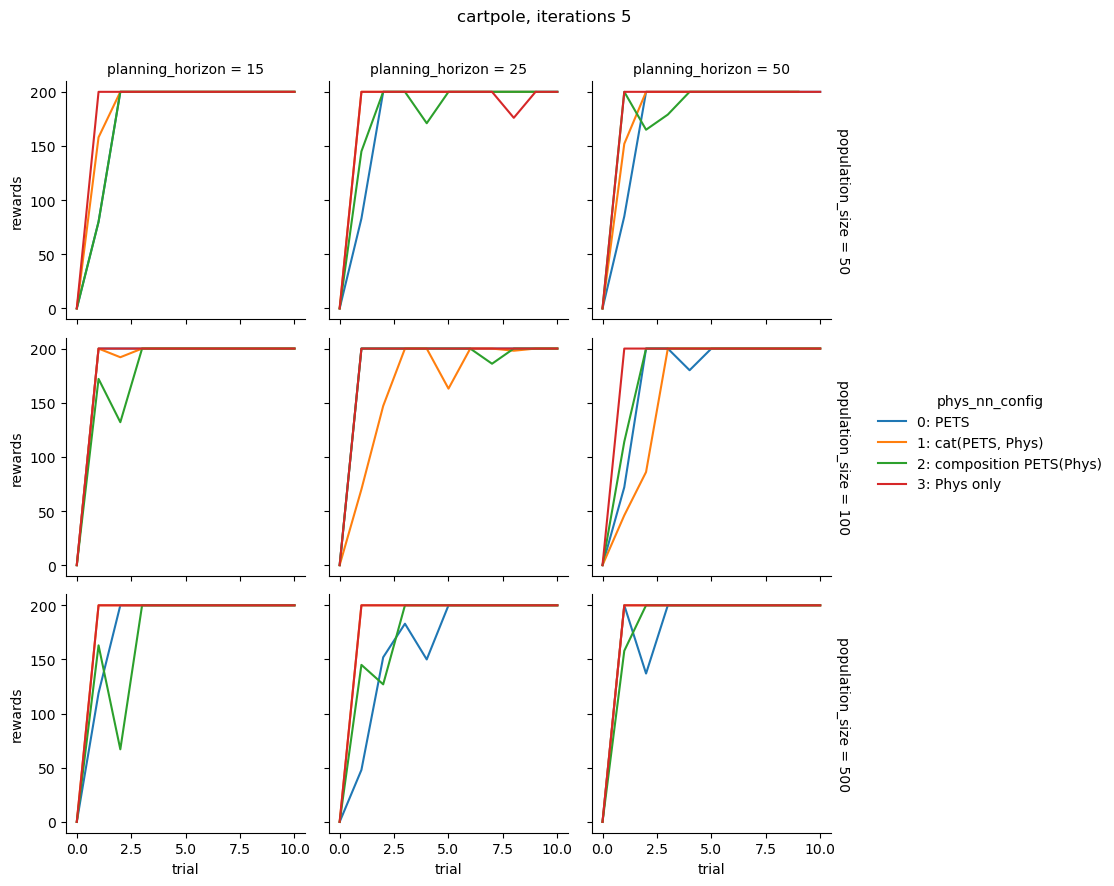

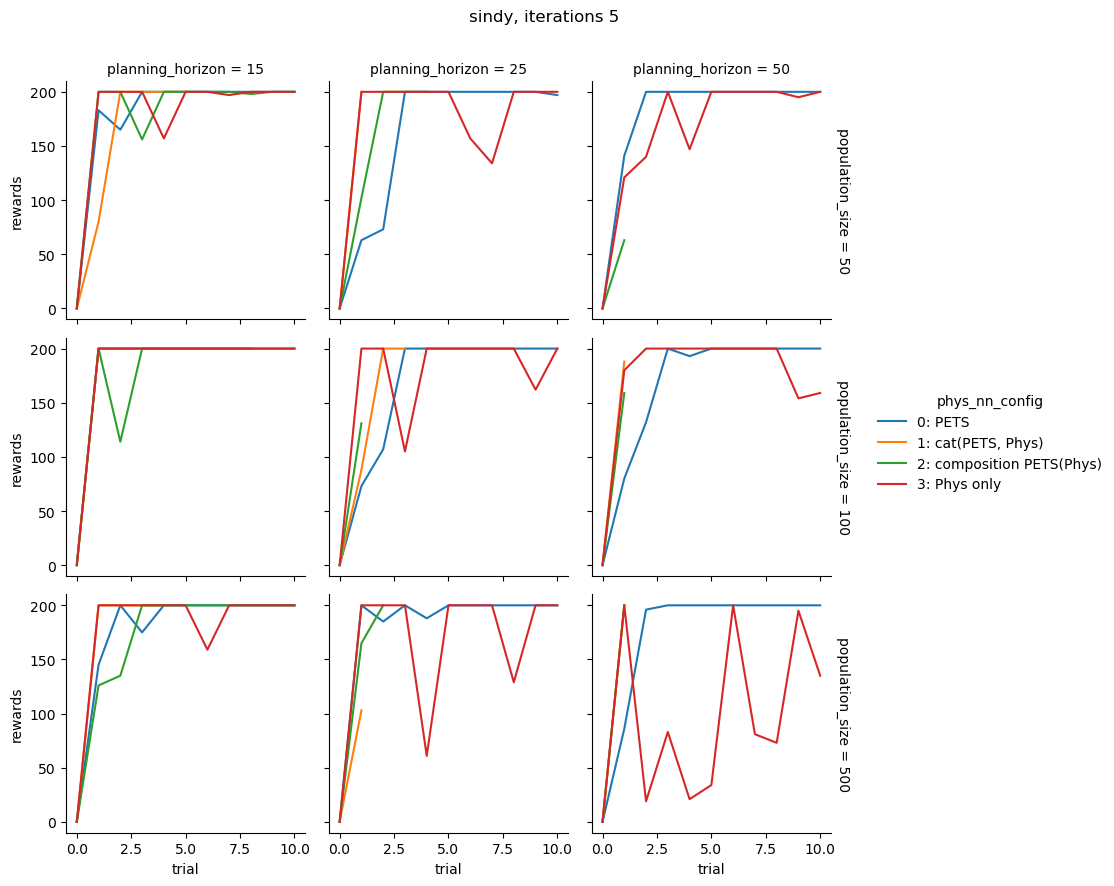

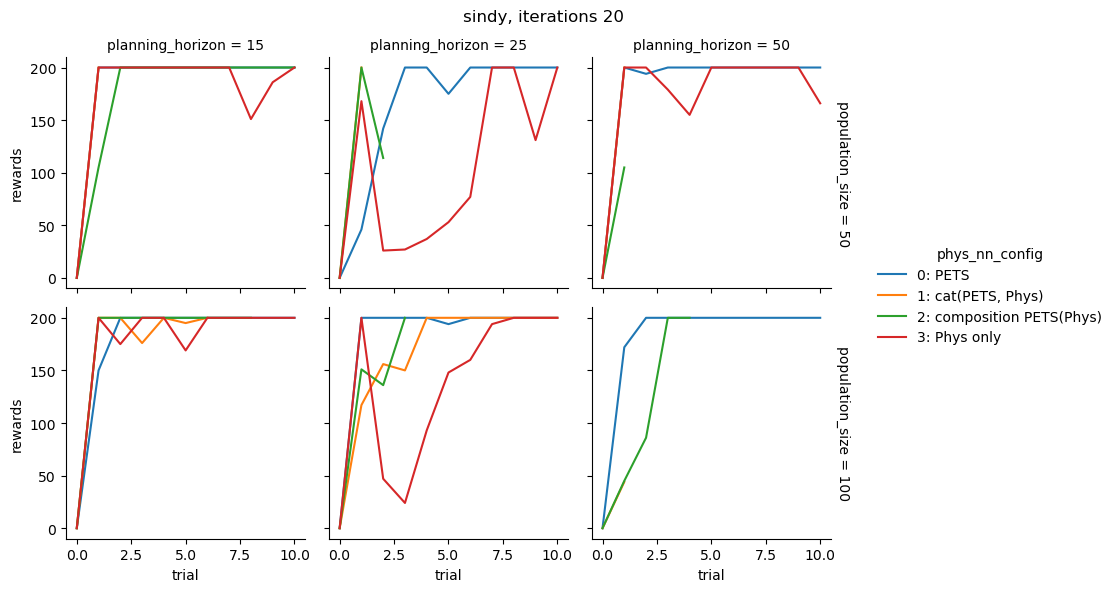

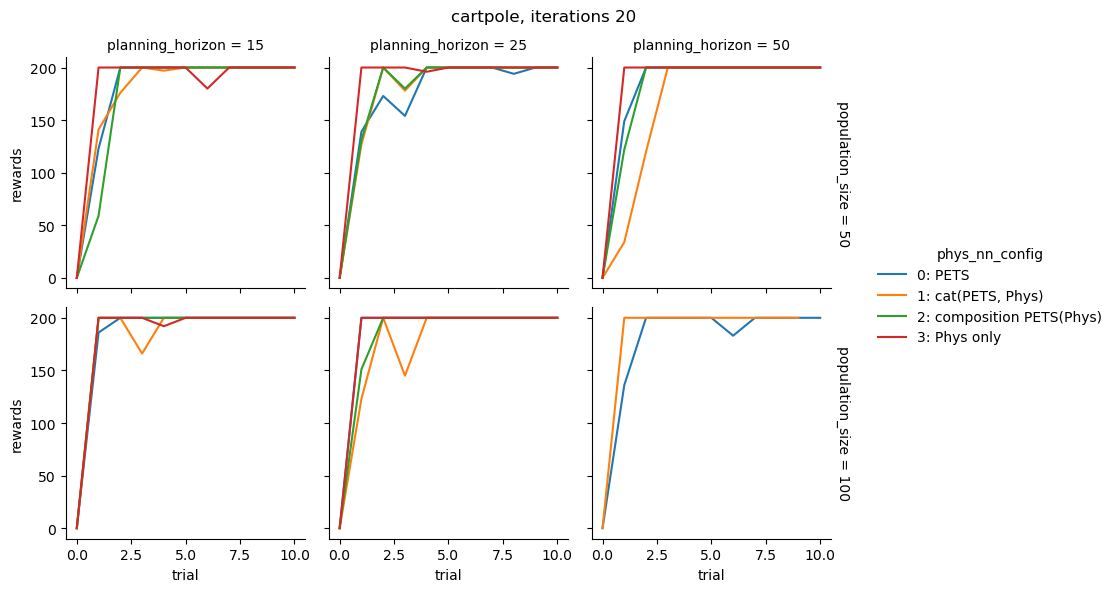

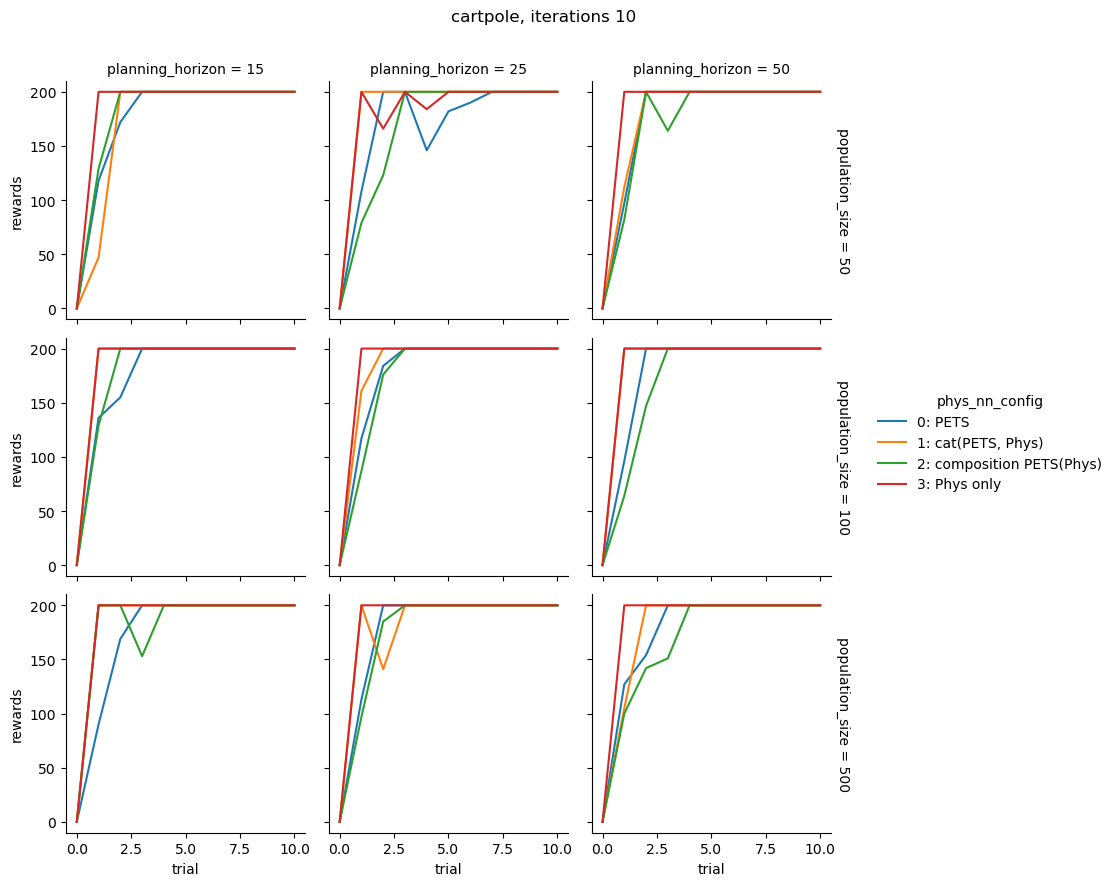

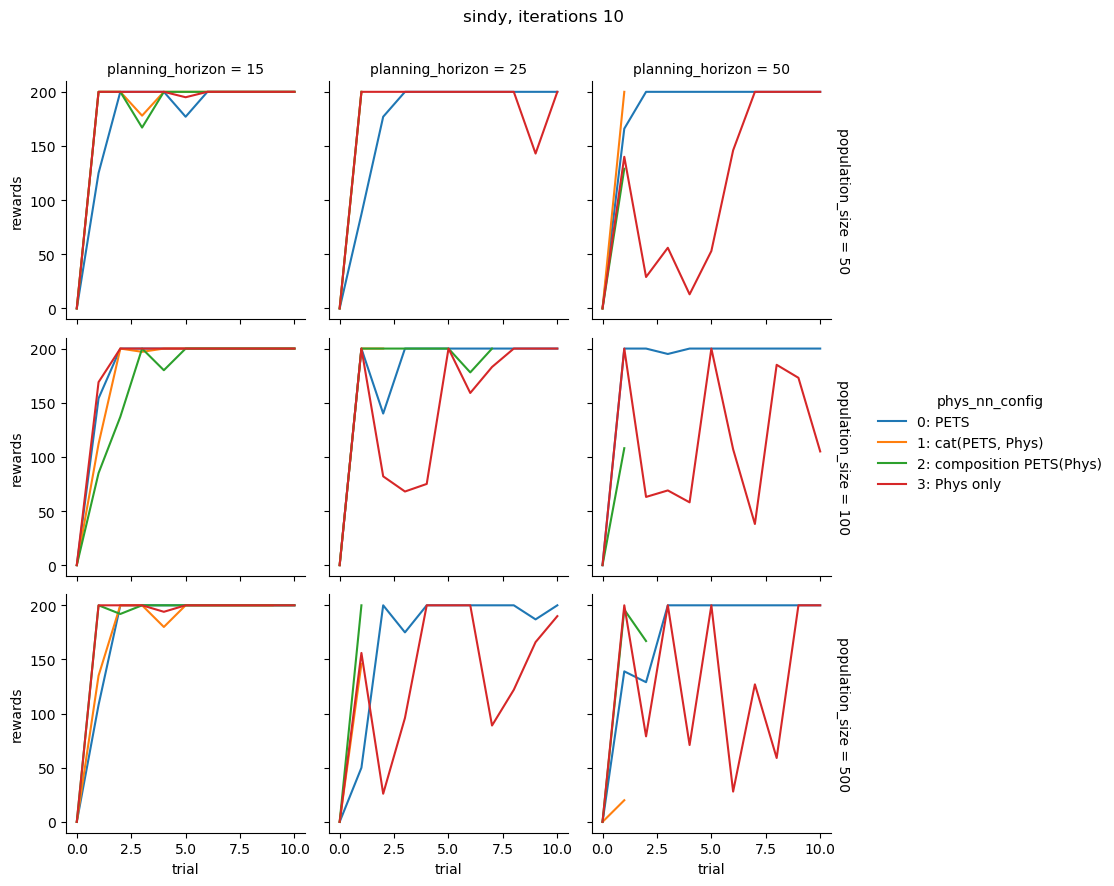

In [110]:

for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    for model in result_i['physics_model'].unique():
        for num_iterations in result_i['num_iterations'].unique():
            
            g = sns.FacetGrid(result_i[result_i['physics_model'] == model], row="population_size", col="planning_horizon",
                            hue = 'phys_nn_config',
                            hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                            margin_titles=True)

            g.map(sns.lineplot, "trial", "rewards", )
            g.add_legend()
            # add title
            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle(model +  ', iterations {}'.format(num_iterations))



# Earlier datasets

In [124]:
data_dir = ['2023-05-04'] 
result_m, result_s = data_to_df(data_dir)

phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'seed']:
    result_s[c] = result_s[c].astype(int)


Time: 04-46-01
OVERRIDES: 

{'optimizer': 'CEM,ICEM,MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-06-58
OVERRIDES: 

{'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-07-05
OVERRIDES: 

{'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 12-07-08
OVERRIDES: 

{'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-58-13
OVERRIDES: 

{'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 12-56-22
OVERRIDES: 

{'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 12-

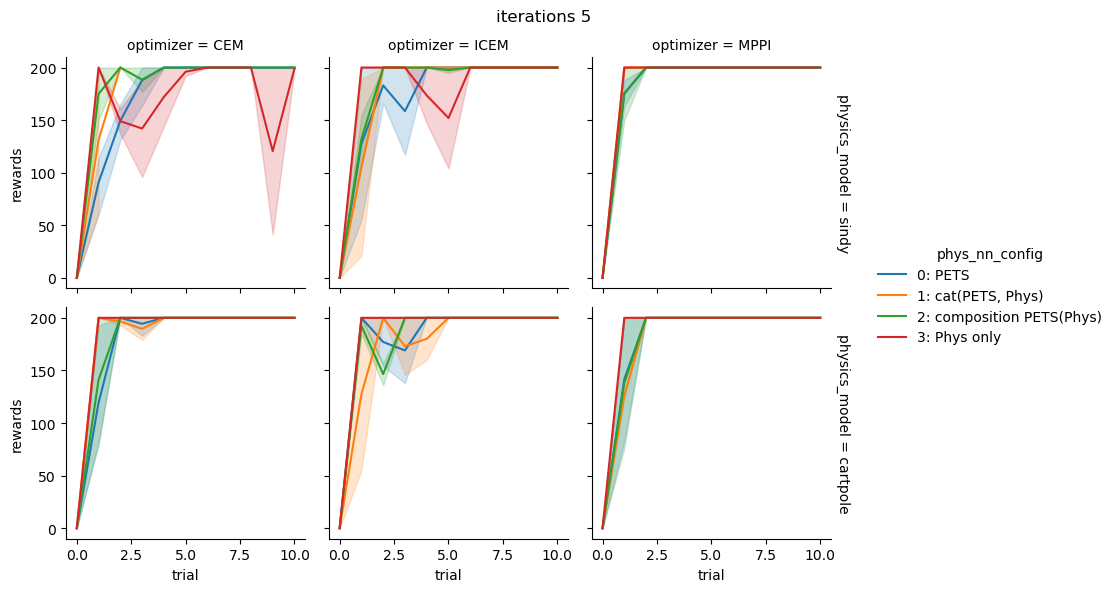

In [125]:
for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    g = sns.FacetGrid(result_i, row="physics_model", col="optimizer",
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards", )
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('iterations {}'.format(num_iterations))


# Friction Results:


Time: 15-57-43
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '1'}
Time: 16-40-08
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'MPPI',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '2'}
Time: 17-56-06
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'ICEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}
Time: 17-55-55
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer': 'CEM',
 'optimizer.num_iterations': '5',
 'phys_nn_config': '0,1,2,3',
 'physics_model': 'sindy,cartpole',
 'seed': '3'}
Time: 16-39-28
OVERRIDES: 

{'env.joint_friction': '0.1',
 'env.track_friction': '0.05',
 'optimizer'

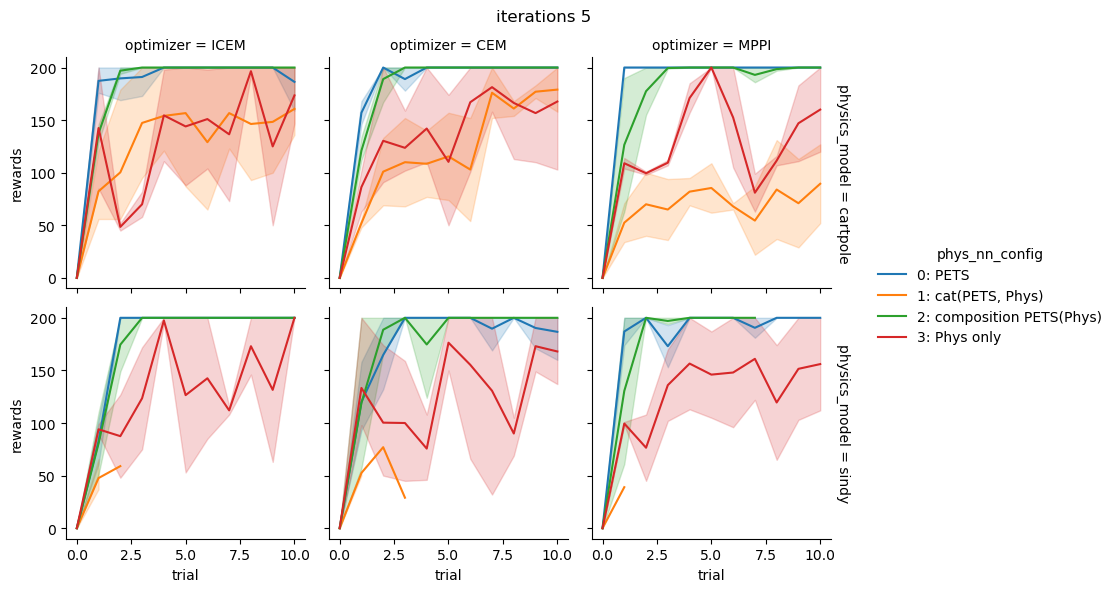

In [123]:
data_dirs = ['2023-05-09_friction2']
result_m, result_s = data_to_df(data_dirs)
phys_nn_config_names = { '0' : '0: PETS', '1' : '1: cat(PETS, Phys)', '2' : '2: composition PETS(Phys)', '3' : '3: Phys only'}
result_s['phys_nn_config'] = result_s['phys_nn_config'].map(phys_nn_config_names)
for c in ['num_iterations', 'seed']:
    result_s[c] = result_s[c].astype(int)




for num_iterations in result_s['num_iterations'].unique():
    result_i = result_s[result_s['num_iterations'] == num_iterations]
    g = sns.FacetGrid(result_i, row="physics_model", col="optimizer",
                    hue = 'phys_nn_config',
                    hue_order = ['0: PETS','1: cat(PETS, Phys)', '2: composition PETS(Phys)', '3: Phys only'] ,
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards")
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('iterations {}'.format(num_iterations))

